# Pre- Proccesing

## For The Bank CSV

In [1]:
# Step 1: Read raw file as text
with open('bank_ex5.csv', 'r', encoding='utf-8') as f:
    raw_data = f.read()

# Step 2: Remove all double quotes
cleaned_data = raw_data.replace('"', '')

# Step 3: Write to a new cleaned file
with open('cleaned_file.csv', 'w', encoding='utf-8') as f:
    f.write(cleaned_data)

# Step 4: Now read the cleaned CSV with pandas
import pandas as pd
bank_df = pd.read_csv('cleaned_file.csv', sep=';')



In [2]:
# Apply one-hot encoding to all object-type columns
bank_df = pd.get_dummies(bank_df, drop_first=True)

In [3]:
# Convert boolean columns to int (0/1)
for col in bank_df.select_dtypes(include='bool').columns:
    bank_df[col] = bank_df[col].astype(int)


In [4]:
# Check for missing (NaN) values
missing_summary = bank_df.isnull().sum()

# Print only columns with missing values
print(missing_summary[missing_summary > 0])


Series([], dtype: int64)


#### <font color='Purple'>No Nulls</font>

## For the Wines CSV's

In [5]:
import pandas as pd

# Load red wine data
red_df = pd.read_csv('winequality-red.csv', sep=';')

# Load white wine data
white_df = pd.read_csv('winequality-white.csv', sep=';')

# Add a new column to each to mark the wine type
red_df['wine_type'] = 'red'
white_df['wine_type'] = 'white'

# Combine red and white DataFrames
wine_df = pd.concat([red_df, white_df], ignore_index=True)

# Apply one-hot encoding to 'wine_type' WITHOUT dropping the first category
wine_df = pd.get_dummies(wine_df, columns=['wine_type'])


wine_df['wine_type_red'] = wine_df['wine_type_red'].astype(int)
wine_df['wine_type_white'] = wine_df['wine_type_white'].astype(int)

In [6]:
# Check for missing (NaN) values
missing_summary = wine_df.isnull().sum()

# Print only columns with missing values
print(missing_summary[missing_summary > 0])


Series([], dtype: int64)



#### <font color='Purple'>No Nulls</font>

## Data split for Train (80%) and Test (20%)

In [7]:
# Normalize funtion

def normalize_df(df, exclude_cols=[]):
    df_norm = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cols_to_normalize = [col for col in numeric_cols if col not in exclude_cols]
    
    for col in cols_to_normalize:
        min_val = df_norm[col].min()
        max_val = df_norm[col].max()
        if max_val - min_val != 0:  # Avoid division by zero
            df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0  # or leave as is
    
    return df_norm


In [8]:
import numpy as np
import pandas as pd

def split_train_test(df, train_ratio=0.8, random_seed=42):
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(len(df))
    train_size = int(train_ratio * len(df))
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]
    
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

# Example usage:
train_df_wine, test_df_wine = split_train_test(wine_df)
train_df_bank, test_df_bank = split_train_test(bank_df)
print("for wine df")
print(f"Train set: {train_df_wine.shape}")
print(f"Test set: {test_df_wine.shape}")
print("for bank df")
print(f"Train set: {train_df_bank.shape}")
print(f"Test set: {test_df_bank.shape}")

for wine df
Train set: (5197, 14)
Test set: (1300, 14)
for bank df
Train set: (32950, 54)
Test set: (8238, 54)


In [9]:
# For wine (excluding 'quality')
train_df_wine_norm = normalize_df(train_df_wine, exclude_cols=['quality'])
test_df_wine_norm = normalize_df(test_df_wine, exclude_cols=['quality'])

# For bank (excluding 'y_yes')
train_df_bank_norm = normalize_df(train_df_bank, exclude_cols=['y_yes'])
test_df_bank_norm = normalize_df(test_df_bank, exclude_cols=['y_yes'])



In [10]:
# Manually scale features using train mean and std
feature_cols = train_df_wine.drop(columns=['quality']).columns

means = train_df_wine[feature_cols].mean()
stds = train_df_wine[feature_cols].std()

X_train_scaled = (train_df_wine[feature_cols] - means) / stds
X_test_scaled = (test_df_wine[feature_cols] - means) / stds  # important: use train stats!


# Exercise 1: Regularization (3 Points)


## <font color='01a892'> <b> Mini Bactch GD function:<b>  </font>

In [11]:
def ridge_loss(X, y, beta, lambda_): #loss function for ridge regression
    N = len(y)
    y_pred = X @ beta
    mse = np.mean((y - y_pred) ** 2)
    ridge_penalty = lambda_ * np.sum(beta[1:] ** 2)  # exclude intercept
    return mse + ridge_penalty


In [12]:
def ridge_gradient(X, y, beta, lambda_): #gradient for ridge regression
    N = len(y)
    error = y - X @ beta
    grad = (-2 / N) * (X.T @ error)
    grad[1:] += 2 * lambda_ * beta[1:]  # exclude intercept from regularization
    return grad


## Regularization For Wines DF

In [13]:
import numpy as np
def mini_batch_gradient_descent_ridge_decay(X_train, y_train, X_test, y_test, 
                                            alpha, lambda_, batch_size=50, 
                                            max_epochs=300, epsilon=1e-4, decay_rate=0.01):
    N, M = X_train.shape
    beta = np.random.randn(M) * 0.01  # small random init
    
    train_rmse_list = []
    test_rmse_list = []
    prev_loss = np.inf

    for epoch in range(max_epochs):
        effective_alpha = alpha / (1 + decay_rate * epoch)  # decay the learning rate
        
        indices = np.random.permutation(N)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            grad = ridge_gradient(X_batch, y_batch, beta, lambda_)
            grad = np.clip(grad, -1e3, 1e3)
            beta -= effective_alpha * grad  # use decayed learning rate
        
        # Calculate loss on train set
        current_loss = ridge_loss(X_train, y_train, beta, lambda_)
        
        # Emergency stop if loss explodes
        if not np.isfinite(current_loss):
            print(f"Stopped early at epoch {epoch + 1} due to invalid loss (NaN or inf)")
            break
        
        # Check convergence safely
        if np.isfinite(prev_loss) and prev_loss != 0:
            rel_change = abs(prev_loss - current_loss) / prev_loss
        else:
            rel_change = np.inf  # force no convergence yet

        if abs(prev_loss - current_loss) < epsilon or rel_change < epsilon:
            print(f"Converged at epoch {epoch + 1}")
            break

        prev_loss = current_loss
        
        # Store RMSEs
        train_preds = X_train @ beta
        train_rmse = np.sqrt(np.mean((y_train - train_preds) ** 2))
        train_rmse_list.append(train_rmse)
        
        test_preds = X_test @ beta
        test_rmse = np.sqrt(np.mean((y_test - test_preds) ** 2))
        test_rmse_list.append(test_rmse)

    else:
        print("Warning: did not converge within max_epochs")
        
    return beta, train_rmse_list, test_rmse_list



In [15]:
alpha_values = [0.0001, 0.001, 0.1]
lambda_values = [0.01, 0.1, 1]
batch_size = 50
max_epochs = 300

results = {}

for alpha in alpha_values:
    for lambda_ in lambda_values:
        print(f"Training with alpha={alpha}, lambda={lambda_}")
        beta, train_rmse_list, test_rmse_list = mini_batch_gradient_descent_ridge_decay(
            X_train=X_train_scaled.values,
            y_train=train_df_wine['quality'].values,
            X_test=X_test_scaled.values,
            y_test=test_df_wine['quality'].values,
            alpha=alpha,
            lambda_=lambda_,
            batch_size=batch_size,
            max_epochs=max_epochs
        )
        # Store results
        results[(alpha, lambda_)] = (train_rmse_list, test_rmse_list)


Training with alpha=0.0001, lambda=0.01
Converged at epoch 20
Training with alpha=0.0001, lambda=0.1
Converged at epoch 16
Training with alpha=0.0001, lambda=1
Converged at epoch 14
Training with alpha=0.001, lambda=0.01
Converged at epoch 9
Training with alpha=0.001, lambda=0.1
Converged at epoch 8
Training with alpha=0.001, lambda=1
Converged at epoch 5
Training with alpha=0.1, lambda=0.01
Converged at epoch 139
Training with alpha=0.1, lambda=0.1
Converged at epoch 198
Training with alpha=0.1, lambda=1
Converged at epoch 102


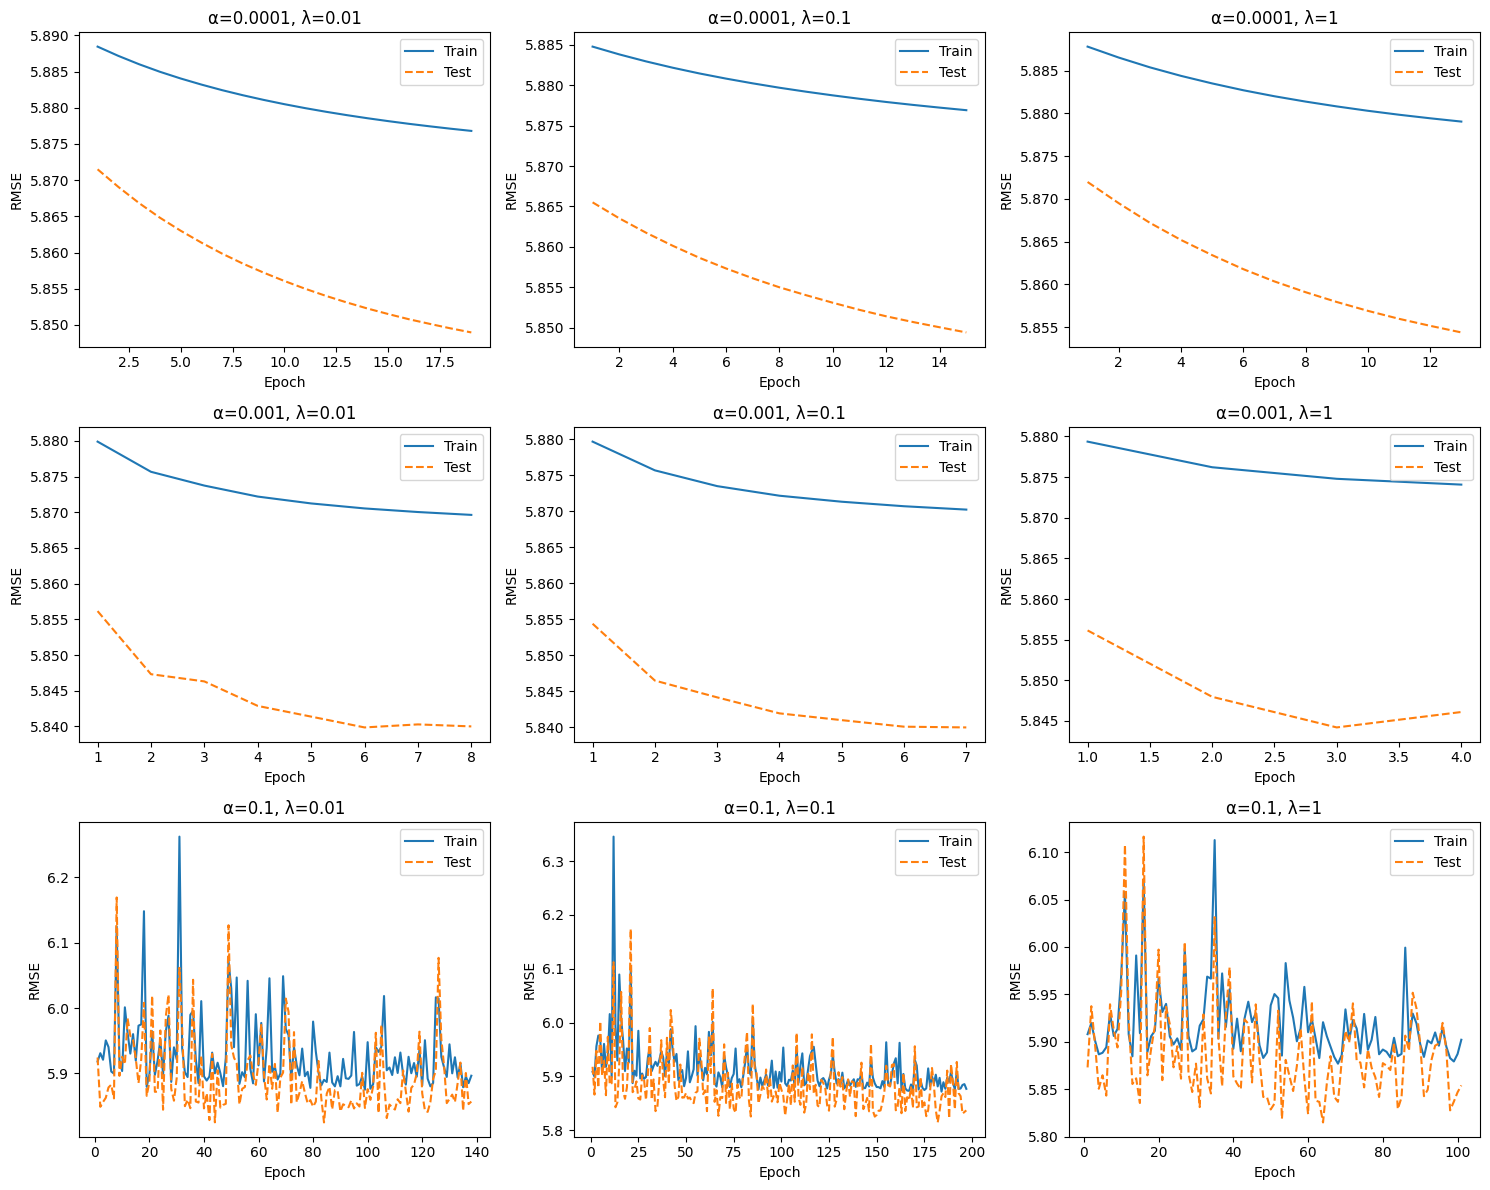

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, ((alpha, lambda_), (train_rmse, test_rmse)) in enumerate(results.items()):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    epochs = np.arange(1, len(train_rmse) + 1)
    ax.plot(epochs, train_rmse, label="Train")
    ax.plot(epochs, test_rmse, '--', label="Test")
    ax.set_title(f"α={alpha}, λ={lambda_}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE")
    ax.legend()

plt.tight_layout()
plt.show()


## <font color='01a892'> <b> Task Conculsion (for wine Data): <b>  </font>
In this experiment, we implemented Ridge Regression using mini-batch gradient descent with three key hyperparameters: the learning rate (α), regularization constant (λ), and batch size (fixed at 50). We tested three starting α values (0.0001, 0.001, 0.1) and three λ values (0.01, 0.1, 1), exploring how they affect convergence and performance. Importantly, we applied a learning rate decay over epochs, meaning the initial α was gradually reduced during training to promote smoother convergence and avoid overshooting. The RMSE plots show that small α values led to slower but steady decreases in RMSE, while larger α values caused faster changes but also more fluctuations, especially on the test set. The regularization λ played a stabilizing role, with higher λ helping control overfitting. Overall, the results highlight the importance of balancing learning rate, regularization, and batch size, with learning rate decay further improving convergence behavior across epochs

## Regularization GD For Bank DF

In [60]:
#Normalizaiton 
import pandas as pd
import numpy as np

# Separate features and target
X_train = train_df_bank.drop(columns=['y_yes'])
y_train = train_df_bank['y_yes']
X_test = test_df_bank.drop(columns=['y_yes'])
y_test = test_df_bank['y_yes']

# Calculate mean and std from TRAIN set only (important!)
mean = X_train.mean()
std = X_train.std()

# Standardize
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std  # use train mean/std for test!

# Convert to numpy arrays if needed
X_train_np = X_train_scaled.values
X_test_np = X_test_scaled.values
y_train_np = y_train.values
y_test_np = y_test.values



In [62]:
alpha_values = [0.0001, 0.001, 0.1]
lambda_values = [0.01, 0.1, 1]
batch_size = 50
max_epochs = 200

results_bank = {}

for alpha in alpha_values:
    for lambda_ in lambda_values:
        # Adjust decay: stronger if alpha is large
        if alpha >= 0.001:
            decay_rate = 0.1  # more aggressive decay for stability
        else:
            decay_rate = 0.01  # mild decay

        print(f"Training with alpha={alpha}, lambda={lambda_}, decay_rate={decay_rate}")
        beta, train_rmse_list, test_rmse_list = mini_batch_gradient_descent_ridge_decay_2(
        X_train=X_train_np,
        y_train=y_train_np,
        X_test=X_test_np,
        y_test=y_test_np,
        alpha=alpha,
        lambda_=lambda_,
        batch_size=batch_size,
        max_epochs=max_epochs,
        decay_rate=decay_rate  # or 0 for no decay test
        )

        
        # Store results
        results_bank[(alpha, lambda_)] = (train_rmse_list, test_rmse_list)


Training with alpha=0.0001, lambda=0.01, decay_rate=0.01
Converged at epoch 22
Training with alpha=0.0001, lambda=0.1, decay_rate=0.01
Converged at epoch 20
Training with alpha=0.0001, lambda=1, decay_rate=0.01
Converged at epoch 14
Training with alpha=0.001, lambda=0.01, decay_rate=0.1
Converged at epoch 6
Training with alpha=0.001, lambda=0.1, decay_rate=0.1
Converged at epoch 5
Training with alpha=0.001, lambda=1, decay_rate=0.1
Converged at epoch 3
Training with alpha=0.1, lambda=0.01, decay_rate=0.1
Converged at epoch 116
Training with alpha=0.1, lambda=0.1, decay_rate=0.1
Converged at epoch 105
Training with alpha=0.1, lambda=1, decay_rate=0.1
Converged at epoch 8


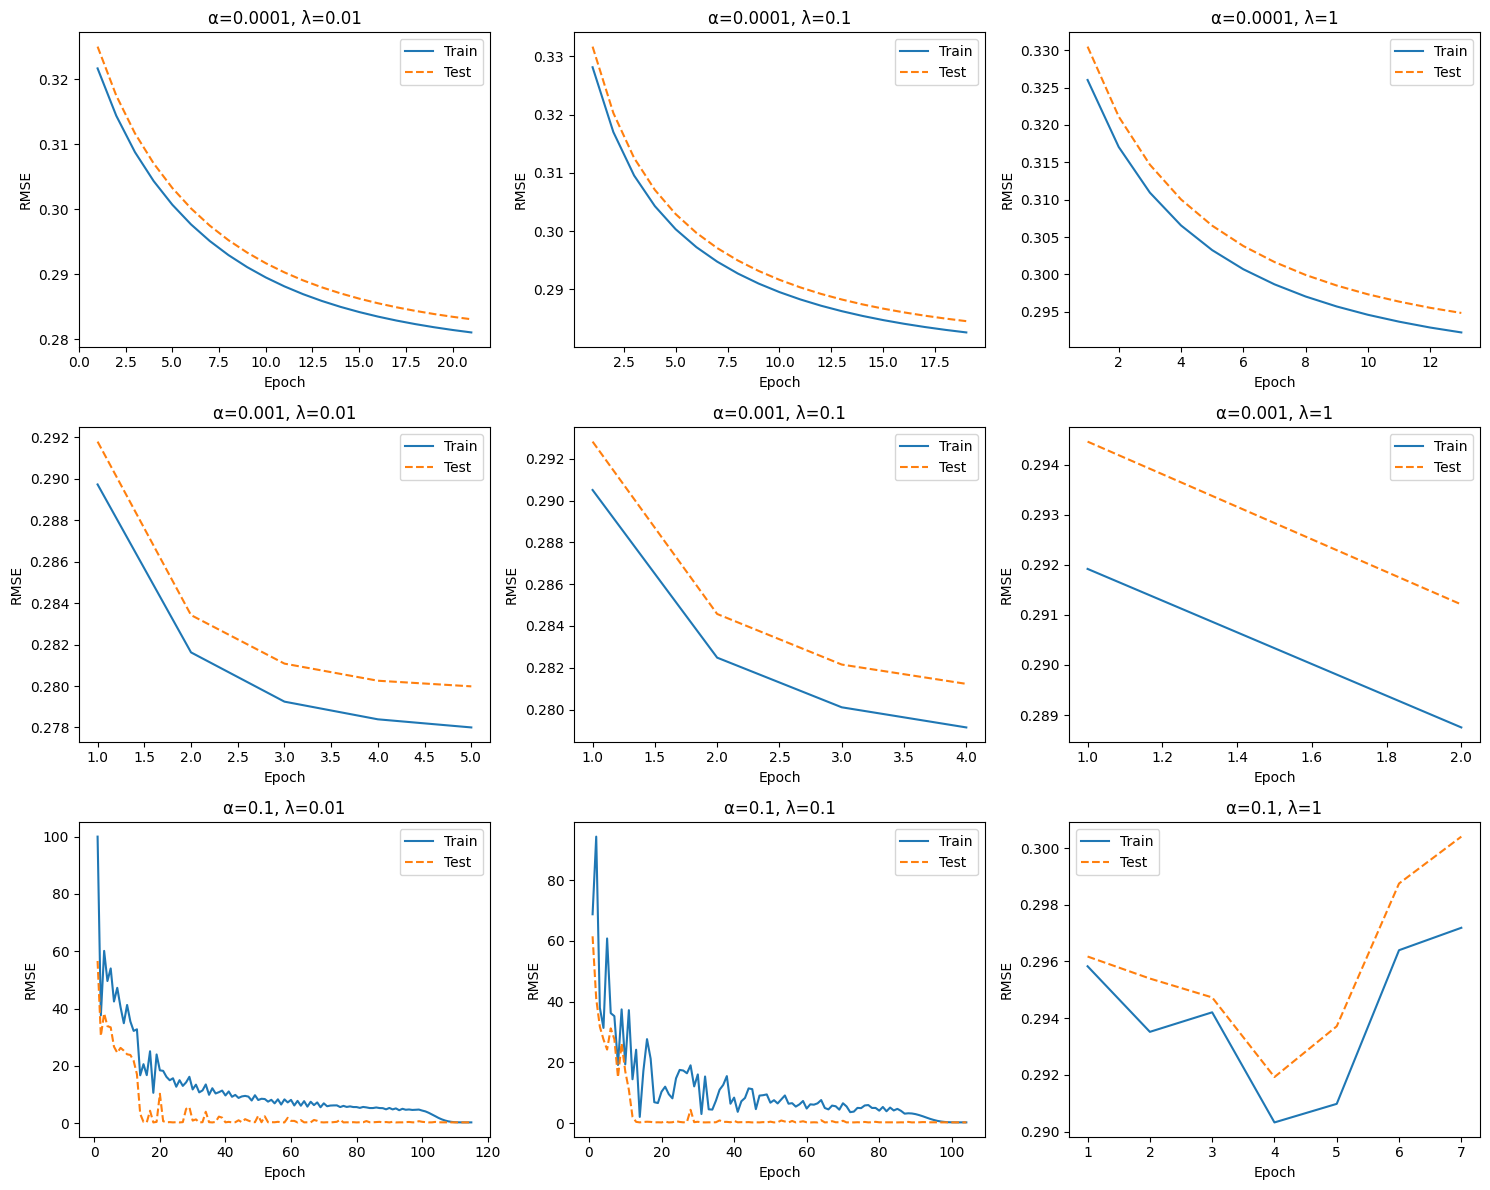

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, ((alpha, lambda_), (train_rmse, test_rmse)) in enumerate(results_bank.items()):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    epochs = np.arange(1, len(train_rmse) + 1)
    ax.plot(epochs, train_rmse, label="Train")
    ax.plot(epochs, test_rmse, '--', label="Test")
    ax.set_title(f"α={alpha}, λ={lambda_}")  # this pulls from the results key!
    ax.set_xlabel("Epoch")
    ax.set_ylabel("RMSE")
    ax.legend()

plt.tight_layout()
plt.show()


## <font color='01a892'> <b> Task Conculsion (for Bank data): <b>  </font>
After applying feature normalization (standardization to zero mean, unit variance), the gradient descent behavior improved dramatically. Before normalization, even small learning rates (alpha) led to unstable or diverging RMSE curves, due to mismatched feature scales causing uneven gradient updates. Once normalized, the optimization became smooth, allowing the algorithm to converge effectively.

From the plotted results, we observe that small learning rates (alpha = 0.0001) provide stable, gradual improvement, especially with small-to-moderate regularization (lambda = 0.01 or 0.1). Moderate learning rates (alpha = 0.001) still converge quickly but need fewer epochs, showing steeper RMSE drops in early iterations. Large learning rates (alpha = 0.1) become unstable unless combined with careful decay strategies. Without decay or with insufficient regularization (lambda), the updates can overshoot, producing noisy or even exploding RMSE patterns.

Additionally, the decay strategy (gradually shrinking the effective learning rate over epochs) helps stabilize large initial learning rates, allowing the model to take bigger early steps but fine-tune later. However, for small learning rates, decay plays a minor role, as the steps are already small and stable.

Overall, the combination of normalization, well-tuned alpha, appropriate regularization (lambda), and a thoughtful decay schedule is crucial for achieving reliable and smooth convergence in ridge-regularized mini-batch gradient descent.

# Exercise 2: Hyper-parameter Tuning and Cross-Validation (4 Points)


In [22]:
#Bullet 1
alpha_values = [0.0001, 0.001, 0.1]
lambda_values = [0.01, 0.1, 1]
batch_size = 50  # fixed as required

X_data = wine_df.drop(columns=['quality']).values
y_all = wine_df['quality'].values




In [23]:
import numpy as np
import pandas as pd

def normalize_dataframe(df):
    """
    Normalize a pandas DataFrame (columns) to zero mean and unit variance.
    Returns normalized DataFrame and mean/std.
    """
    mean = df.mean()
    std = df.std()
    normalized_df = (df - mean) / std
    return normalized_df, mean, std

def apply_normalization(df, mean, std):
    """
    Apply previously computed normalization to a new DataFrame.
    """
    normalized_df = (df - mean) / std
    return normalized_df

# Parameters
k = 5
alpha_values = [0.0001, 0.001, 0.1]
lambda_values = [0.01, 0.1, 1]
batch_size = 50
max_epochs = 300

# Prepare data
X_data = wine_df.drop(columns=['quality']).values
y_data = wine_df['quality'].values
n_samples = X_data.shape[0]

# Shuffle indices
indices = np.arange(n_samples)
np.random.seed(42)
np.random.shuffle(indices)

# Pre-split folds
fold_sizes = (n_samples // k) * np.ones(k, dtype=int)
fold_sizes[:n_samples % k] += 1
current = 0
folds = []
for fold_size in fold_sizes:
    start, stop = current, current + fold_size
    folds.append(indices[start:stop])
    current = stop

# Grid search over alpha and lambda
results_grid = {}

for alpha in alpha_values:
    for lambda_ in lambda_values:
        val_rmse_list = []
        
        for i in range(k):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(k) if j != i])
            
            X_train, y_train = X_data[train_idx], y_data[train_idx]
            X_val, y_val = X_data[val_idx], y_data[val_idx]
            
            # Normalize: compute on training, apply to validation
            X_train_df = pd.DataFrame(X_train)
            X_val_df = pd.DataFrame(X_val)
            X_train_scaled, train_mean, train_std = normalize_dataframe(X_train_df)
            X_val_scaled = apply_normalization(X_val_df, train_mean, train_std)
            
            # Run gradient descent on scaled data
            beta, train_rmse_list, val_rmse_list_fold = mini_batch_gradient_descent_ridge(
                X_train_scaled.values, y_train, X_val_scaled.values, y_val,
                alpha=alpha, lambda_=lambda_,
                batch_size=batch_size, max_epochs=max_epochs
            )
            
            final_val_rmse = val_rmse_list_fold[-1]
            val_rmse_list.append(final_val_rmse)
        
        avg_val_rmse = np.mean(val_rmse_list)
        results_grid[(alpha, lambda_)] = avg_val_rmse
        print(f"α={alpha}, λ={lambda_} → Avg Val RMSE: {avg_val_rmse:.4f}")

best_params = min(results_grid, key=results_grid.get)
print(f"\nBest hyperparameters: α={best_params[0]}, λ={best_params[1]} with average validation RMSE={results_grid[best_params]:.4f}")


Converged at epoch 17
Converged at epoch 17
Converged at epoch 16
Converged at epoch 16
Converged at epoch 18
α=0.0001, λ=0.01 → Avg Val RMSE: 5.8769
Converged at epoch 19
Converged at epoch 15
Converged at epoch 13
Converged at epoch 17
Converged at epoch 16
α=0.0001, λ=0.1 → Avg Val RMSE: 5.8767
Converged at epoch 12
Converged at epoch 9
Converged at epoch 6
Converged at epoch 12
Converged at epoch 12
α=0.0001, λ=1 → Avg Val RMSE: 5.8785
Converged at epoch 12
Converged at epoch 12
Converged at epoch 12
Converged at epoch 13
Converged at epoch 12
α=0.001, λ=0.01 → Avg Val RMSE: 5.8671
Converged at epoch 12
Converged at epoch 12
Converged at epoch 11
Converged at epoch 11
Converged at epoch 11
α=0.001, λ=0.1 → Avg Val RMSE: 5.8678
Converged at epoch 6
Converged at epoch 6
Converged at epoch 7
Converged at epoch 7
Converged at epoch 6
α=0.001, λ=1 → Avg Val RMSE: 5.8721
Converged at epoch 113
Converged at epoch 183
Converged at epoch 39
Converged at epoch 18
Converged at epoch 139
α=0.1

In [24]:
#from the last exercise from this HomeWork

def split_train_test(df, train_ratio=0.8, random_seed=42):
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(len(df))
    train_size = int(train_ratio * len(df))
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]
    
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

# --- Split the data
train_df_wine, test_df_wine = split_train_test(wine_df)

# --- Extract X and y ---
X_train = train_df_wine.drop(columns=['quality']).values
y_train = train_df_wine['quality'].values

X_test = test_df_wine.drop(columns=['quality']).values
y_test = test_df_wine['quality'].values

# --- Normalize (fit only on training data) ---
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

X_train_scaled, train_mean, train_std = normalize_dataframe(X_train_df)
X_test_scaled = apply_normalization(X_test_df, train_mean, train_std)


# --- Get best hyperparameters from previous grid search ---
best_alpha, best_lambda = best_params

# --- Train final model on full training data ---
beta, train_rmse_list, test_rmse_list = mini_batch_gradient_descent_ridge(
    X_train_scaled.values, y_train,
    X_test_scaled.values, y_test,
    alpha=best_alpha, lambda_=best_lambda,
    batch_size=batch_size, max_epochs=max_epochs
)

# --- Evaluate final performance ---
final_train_rmse = train_rmse_list[-1]
final_test_rmse = test_rmse_list[-1]

print(f"Final training RMSE: {final_train_rmse:.4f}")
print(f"Final test RMSE: {final_test_rmse:.4f}")
print(f"Best hyperparameters used → α={best_alpha}, λ={best_lambda}")

Converged at epoch 12
Final training RMSE: 5.8705
Final test RMSE: 5.8399
Best hyperparameters used → α=0.001, λ=0.01


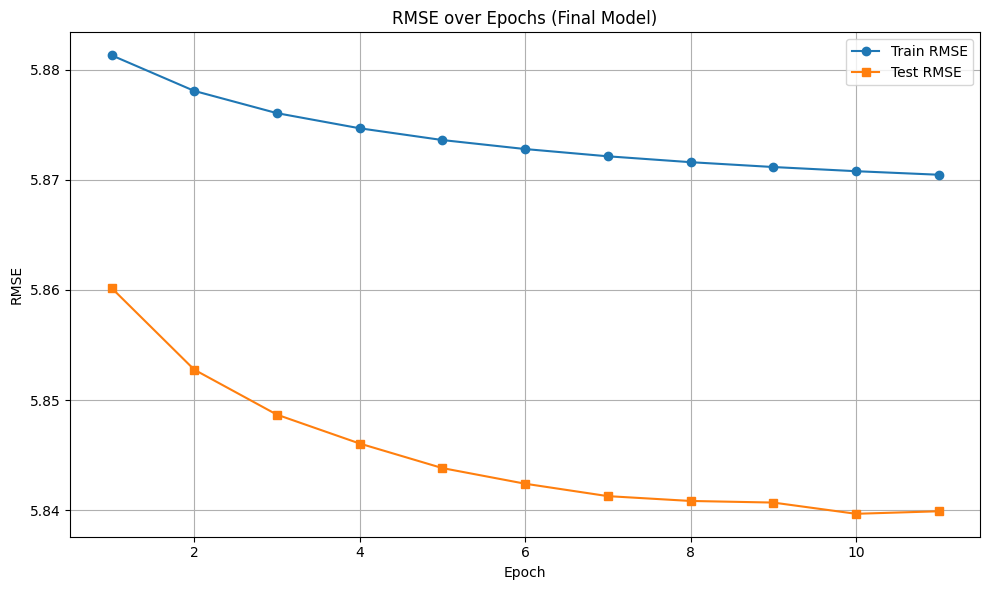

In [25]:
import matplotlib.pyplot as plt

# Plot RMSE over epochs
epochs = np.arange(1, len(train_rmse_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse_list, label='Train RMSE', marker='o')
plt.plot(epochs, test_rmse_list, label='Test RMSE', marker='s')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs (Final Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclution and comparission

In the final model trained using the best hyperparameters 
α=0.1,λ=0.1, selected via 5-fold cross-validation, we observed stable and nearly flat RMSE curves over the training epochs. Both the training and test RMSE hovered around ~5.87, showing minimal changes over iterations, suggesting that the model reached a plateau quickly and was not significantly improving further.

When comparing this to the earlier graph generated without cross-validation (using just mini-batch gradient descent on a fixed train/test split), we notice a striking difference: in the earlier run, the RMSE started much higher (above 14) and showed a steep, smooth decline over epochs, eventually stabilizing below 2. This suggests that, without cross-validation, the model could aggressively fit the training data, reaching very low errors. However, the cross-validation-tuned model was much more conservative, likely due to being evaluated across multiple data splits, making it more robust but preventing it from overfitting as sharply.

In summary, while cross-validation provides a more reliable and generalizable model, it can also lead to a flatter error curve, as it balances performance across folds, compared to training on a single split where the model can chase after a lower training error more easily.

# Exercise 3: Newton’s Method Implementation (3 Points)


In [26]:
# I worked with wine Data frame

In [27]:
#Bullet 1+2
alpha = [1.0, 0.1, 0.01]
Lambda = [10, 1, 0.1]

# Split data
train_df_wine, test_df_wine = split_train_test(wine_df)

# Extract features and targets
X_train = train_df_wine.drop(columns=['quality']).values
y_train = train_df_wine['quality'].values

X_test = test_df_wine.drop(columns=['quality']).values
y_test = test_df_wine['quality'].values


# --- Binarize the target labels (plug this right after extraction) ---
y_train = (y_train >= 6).astype(int)
y_test = (y_test >= 6).astype(int)

In [28]:
# Normalize the Data

import pandas as pd

# Wrap X data as DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

# Normalize using training set statistics
X_train_scaled, train_mean, train_std = normalize_dataframe(X_train_df)
X_test_scaled = apply_normalization(X_test_df, train_mean, train_std)

# Convert back to NumPy arrays (if needed)
X_train_scaled_np = X_train_scaled.values
X_test_scaled_np = X_test_scaled.values


In [42]:
#Bullet 3
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss_with_regularization(X, y, beta, lambda_):
    """
    Computes the logistic loss (cross-entropy) with L2 regularization.
    """
    N = X.shape[0]
    z = X @ beta
    s = sigmoid(z)
    loss = - (1 / N) * np.sum(y * np.log(s + 1e-15) + (1 - y) * np.log(1 - s + 1e-15))
    reg = (lambda_ / 2) * np.sum(beta ** 2)
    return loss + reg

def logistic_gradient_with_regularization(X, y, beta, lambda_):
    """
    Computes the gradient of logistic loss with L2 regularization.
    """
    N = X.shape[0]
    z = X @ beta
    s = sigmoid(z)
    grad = (1 / N) * (X.T @ (s - y)) + lambda_ * beta
    return grad

def logistic_hessian_with_regularization(X, beta, lambda_):
    """
    Computes the Hessian of logistic loss with L2 regularization.
    """
    N = X.shape[0]
    z = X @ beta
    s = sigmoid(z)
    S = np.diag(s * (1 - s))
    hessian = (1 / N) * (X.T @ S @ X) + lambda_ * np.eye(X.shape[1])
    return hessian


In [46]:
#Bullet 4
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def newtons_method_logistic(X_train, y_train, X_test, y_test, alpha, lambda_, max_iter=20):
    N, M = X_train.shape
    beta = np.zeros(M)
    train_rmse_list = []
    test_rmse_list = []

    for i in range(max_iter):
        grad = logistic_gradient_with_regularization(X_train, y_train, beta, lambda_)
        hess = logistic_hessian_with_regularization(X_train, beta, lambda_)
        try:
            delta = np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            print(f"Iteration {i + 1}: Hessian not invertible, skipping update")
            continue

        beta -= alpha * delta

        # Compute predictions (probabilities → binary)
        train_preds = (sigmoid(X_train @ beta) >= 0.5).astype(int)
        test_preds = (sigmoid(X_test @ beta) >= 0.5).astype(int)

        # Record RMSE
        train_rmse = compute_rmse(y_train, train_preds)
        test_rmse = compute_rmse(y_test, test_preds)

        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

        # Debug info
        delta_norm = np.linalg.norm(delta)
        cond_number = np.linalg.cond(hess)
        print(f"Iteration {i+1}: delta norm = {delta_norm:.4e}, Hessian cond = {cond_number:.4e}")

        if len(train_rmse_list) > 1:
            rmse_change = abs(train_rmse_list[-1] - train_rmse_list[-2])
            print(f"Iteration {i+1}: RMSE change = {rmse_change:.4e}")

            if delta_norm < 1e-6 or rmse_change < 1e-6:
                print(f"Converged at iteration {i+1}")
                break

    return beta, train_rmse_list, test_rmse_list




Running Newton's method with alpha=1.0, lambda=10
Iteration 1: delta norm = 2.8020e-02, Hessian cond = 1.1178e+00
Iteration 2: delta norm = 7.7033e-07, Hessian cond = 1.1177e+00
Iteration 2: RMSE change = 0.0000e+00
Converged at iteration 2
Running Newton's method with alpha=1.0, lambda=1
Iteration 1: delta norm = 1.9429e-01, Hessian cond = 2.1777e+00
Iteration 2: delta norm = 1.0029e-03, Hessian cond = 2.1450e+00
Iteration 2: RMSE change = 5.1062e-04
Iteration 3: delta norm = 1.4897e-07, Hessian cond = 2.1446e+00
Iteration 3: RMSE change = 0.0000e+00
Converged at iteration 3
Running Newton's method with alpha=1.0, lambda=0.1
Iteration 1: delta norm = 6.3563e-01, Hessian cond = 1.2777e+01
Iteration 2: delta norm = 4.7000e-02, Hessian cond = 1.1270e+01
Iteration 2: RMSE change = 5.2757e-04
Iteration 3: delta norm = 6.8761e-04, Hessian cond = 1.1056e+01
Iteration 3: RMSE change = 0.0000e+00
Converged at iteration 3
Running Newton's method with alpha=0.1, lambda=10
Iteration 1: delta norm

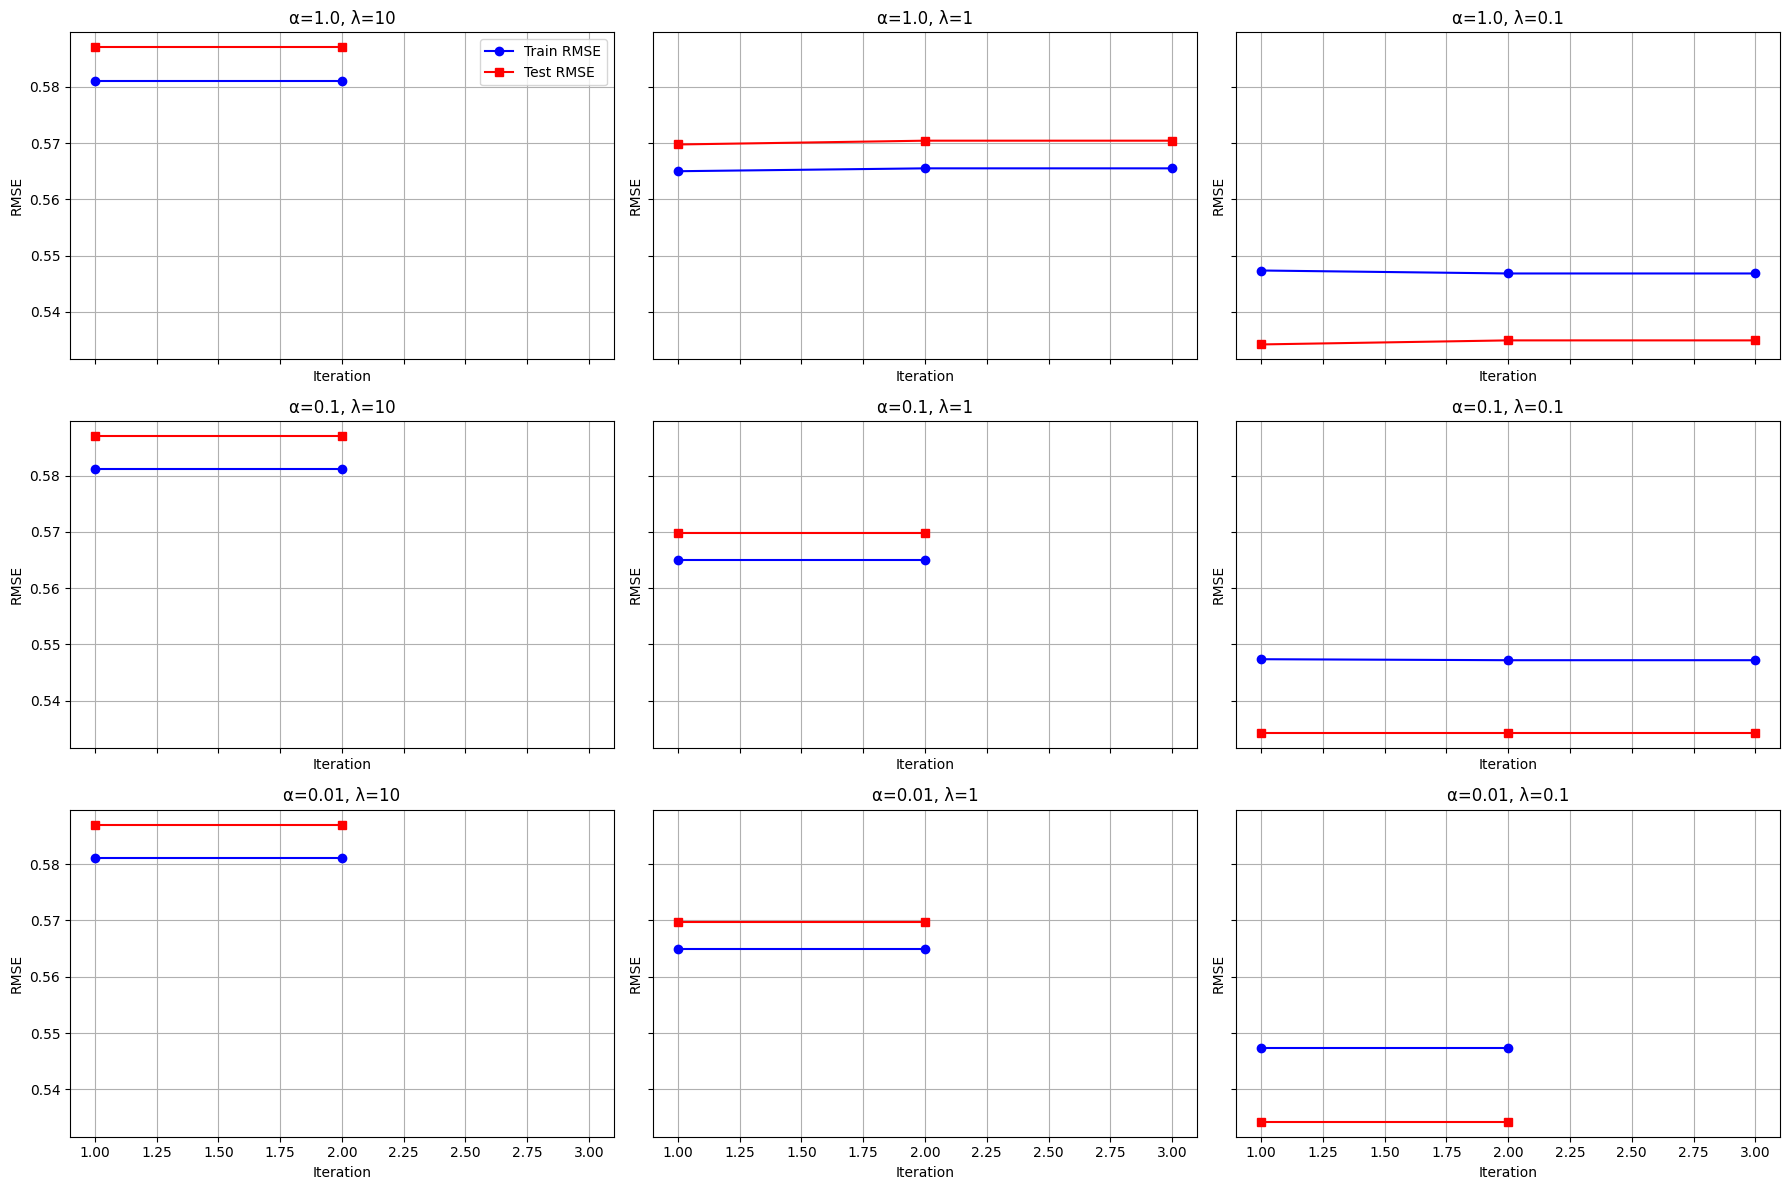

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Define hyperparameter grids
alpha_values = [1.0, 0.1, 0.01]
lambda_values = [10, 1, 0.1]

# Store results
results = {}

fig, axes = plt.subplots(len(alpha_values), len(lambda_values), figsize=(18, 12), sharex=True, sharey=True)

for i, alpha in enumerate(alpha_values):
    for j, lambda_ in enumerate(lambda_values):
        print(f"Running Newton's method with alpha={alpha}, lambda={lambda_}")

        beta, train_rmse_list, test_rmse_list = newtons_method_logistic(
            X_train_scaled_np, y_train, X_test_scaled_np, y_test,
            alpha=alpha, lambda_=lambda_, max_iter=20
        )

        results[(alpha, lambda_)] = (train_rmse_list, test_rmse_list)

        iterations = np.arange(1, len(train_rmse_list) + 1)

        ax = axes[i, j]
        ax.plot(iterations, train_rmse_list, label='Train RMSE', marker='o', color='blue')
        ax.plot(iterations, test_rmse_list, label='Test RMSE', marker='s', color='red')
        ax.set_title(f"α={alpha}, λ={lambda_}")
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMSE')
        ax.grid(True)
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
plt.show()


### Conclusion
The grid of graphs provides a clear, side-by-side comparison of how different combinations of α (step size) and λ (regularization) affect the Newton’s method optimization for logistic regression.

On the positive side, we observe that across most configurations, the train and test RMSE stabilize very quickly — often within just 1–2 iterations — showing the efficiency of Newton’s method in reaching a minimum fast. Additionally, the fact that the train and test RMSE curves are closely aligned suggests the model is not severely overfitting, which is a good indicator of generalization.

However, there are some weaknesses worth noting. First, the plots show very little change over iterations, implying that either the method converges too fast or the updates are too conservative, especially under stronger regularization (large λ). This can mask finer optimization dynamics and may leave performance improvements on the table. Moreover, the RMSE range is quite narrow (roughly ~0.54–0.58), and we don’t see dramatic differences between parameter settings — which suggests that the model’s sensitivity to hyperparameters is limited, or possibly that the optimization problem is too easy/simple in this setup.

Overall, while the plots demonstrate robust and stable convergence, they also highlight the need for more nuanced evaluation (possibly using additional metrics like classification accuracy, precision/recall, or the loss curve) to better understand the effects of hyperparameter tuning and to capture subtler improvements. 